<a href="https://colab.research.google.com/github/rishika-saha/Computer_Vision/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Oct  8 06:51:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

***Importing the Dataset directly from Kaggle***

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip
!rm open-images-bus-trucks.zip

***Importing Libraries***

In [ ]:
!pip install torch-snippets
from PIL import Image
from torch_snippets import *
import numpy as np
import pandas as pd
import cv2
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from numpy import moveaxis
from numpy import asarray
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [ ]:
dataset=pd.read_csv('/content/df.csv')
dataset.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,IsGroupOf,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,0,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,0,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,0,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,0,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,0,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
img_folder = '/content/images/images/'

In [ ]:
class OpenDataset(Dataset):
  def __init__(self,data):
    self.data=data
  def __len__(self):
    return len(self.data)
  def __getitem__(self,ix):
    image = self.data.iloc[ix,0]
    image = image + '.jpg'
    image_path = os.path.join(img_folder, image)
    img = (cv2.imread(image_path)[:,:,::-1])
    img = cv2.resize(img, (224, 224))/255
    img = asarray(img)
    img = moveaxis(img, 2, 0)
    img = torch.tensor(img)
    box = self.data.iloc[ix,4:8].values
    temp = box[1]
    box[1] = box[2]
    box[2] = temp
    classes = self.data.iloc[ix,2]
    if (classes=='Bus'):
      classes=[0]
    elif (classes=='Truck'):
      classes=[1]
    box=[(box* np.array([224,224,224,224])).astype(np.uint16).tolist()]
    target={}
    target["boxes"]=torch.tensor(box).float().to(device)
    target["labels"]=torch.tensor(classes).long().to(device)     
    return img.to(device).float(), target
  def collate_fn(self, batch):
    return tuple(zip(*batch))

In [ ]:
test = OpenDataset(dataset)
img, target= test[1]
print(target)

{'boxes': tensor([[ 61.,  31., 156.,  97.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0')}


In [ ]:
from torch.utils.data import DataLoader
train = OpenDataset(dataset[:1000])
train_loader = DataLoader(train, batch_size=8, collate_fn=train.collate_fn ,drop_last=True)

In [ ]:
def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3)
  return model.to(device)

In [ ]:
def train_batch(images, targets, model, optimizer):
 model.train()
 input = list(image for image in images)
 targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
 optimizer.zero_grad()
 losses = model(input, targets)
 loss = sum(loss for loss in losses.values())
 loss.backward()
 optimizer.step()
 return loss, losses

In [ ]:
model=get_model()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9,weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


1
2
3
4
5
6
7
8
9


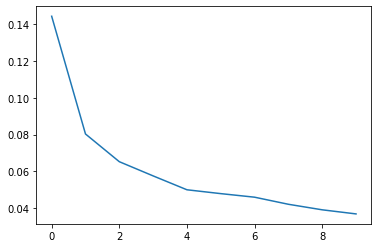

In [ ]:
Loss=[]
for epoch in range(0, 10):
  print(epoch)
  batch_loss=[]
  for ix , inputs in enumerate(train_loader):
    img, target = inputs
    loss, losses = train_batch(img, target, model, optimizer)
    batch_loss.append(loss.item())
  Loss.append(np.mean(batch_loss))

plt.plot(Loss)

***Prediction***

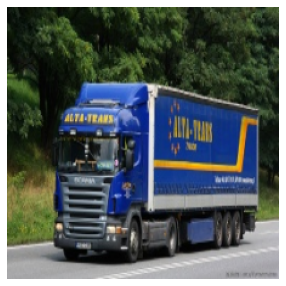

In [ ]:
img_path='/content/images/images/00072b81abc72d21.jpg'
img=(cv2.imread(img_path)[:,:,::-1])
img=cv2.resize(img, (224, 224))/255
show(img)

In [ ]:
model.eval()
img=asarray(img)
img=moveaxis(img, 2, 0)
img = torch.tensor(img).float().view(-1, 3, 224, 224).to(device)
target_final=model(img)
print(target_final)

[{'boxes': tensor([[ 35.0386,  54.4418, 207.5527, 208.4579]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9594], device='cuda:0', grad_fn=<IndexBackward>)}]


In [ ]:
result=target_final[0]['boxes'].cpu().detach().numpy()
label=target_final[0]['labels'].cpu().detach().numpy()
scores=target_final[0]['scores'].cpu().detach().numpy()
xy=label.tolist()
for i in range(len(xy)):
    if(xy[i]==0):
        xy[i]='Bus'
    elif(xy[i]==1):
        xy[i]='Truck'
print(scores)

[0.959403]


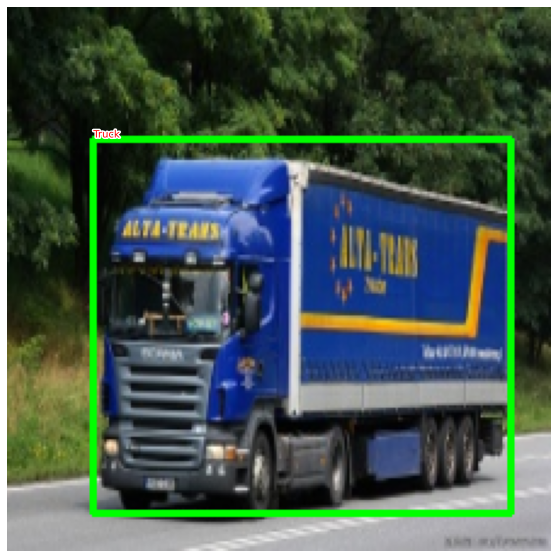

In [ ]:
img1=read(img_path, 1)
img1=cv2.resize(img1, (224, 224))
show(img1, bbs=result, texts=xy ,sz=10)